# RNN

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class TimeSeriesData():
    
    def __init__(self, num_points, xmin, xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax - xmin)/num_points
        self.x_data = np.linspace(xmin, xmax, num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self, x_series):
        return np.sin(x_series)
    
    def next_batch(self, batch_size, steps, return_batch_ts=False):
        
        # Grab a random starting point for each batch
        rand_start = np.random.rand(batch_size, 1)
        
        # Convert to be on time series
        ts_start = rand_start * (self.xmax - self.xmin - (steps * self.resolution))
        
        # Create batch time serie on the x axis
        batch_ts = ts_start + np.arange(0.0, steps+1) * self.resolution
        
        # Create the Y data for the time series x axis from previous step
        y_batch = np.sin(batch_ts)
        
        # FORMATTING for RNN
        if return_batch_ts:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1), batch_ts
        else:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1)

In [3]:
ts_data = TimeSeriesData(250, 0, 10)

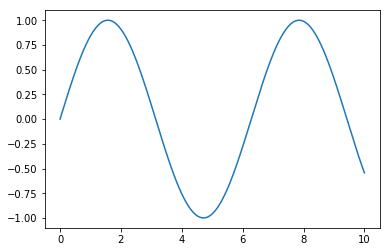

In [13]:
plt.plot(ts_data.x_data, ts_data.y_true)

In [14]:
num_time_steps = 30

In [15]:
y1, y2, ts = ts_data.next_batch(1, num_time_steps, True)

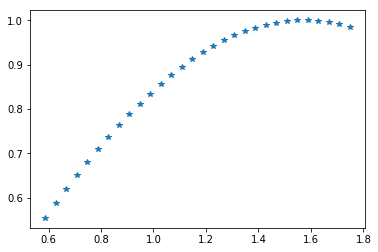

In [16]:
plt.plot(ts.flatten()[1:], y2.flatten(), '*')

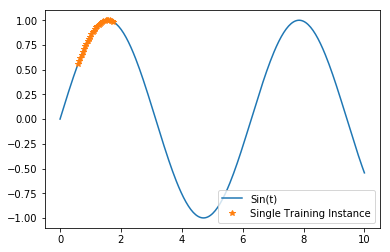

In [17]:
plt.plot(ts_data.x_data, ts_data.y_true, label='Sin(t)')
plt.plot(ts.flatten()[1:], y2.flatten(), '*', label="Single Training Instance")

plt.legend()

In [18]:
# TRAINING DATA

In [19]:
train_inst = np.linspace(5, 5 + ts_data.resolution*(num_time_steps+1), num_time_steps+1)

In [20]:
train_inst

array([ 5.        ,  5.04133333,  5.08266667,  5.124     ,  5.16533333,
        5.20666667,  5.248     ,  5.28933333,  5.33066667,  5.372     ,
        5.41333333,  5.45466667,  5.496     ,  5.53733333,  5.57866667,
        5.62      ,  5.66133333,  5.70266667,  5.744     ,  5.78533333,
        5.82666667,  5.868     ,  5.90933333,  5.95066667,  5.992     ,
        6.03333333,  6.07466667,  6.116     ,  6.15733333,  6.19866667,
        6.24      ])

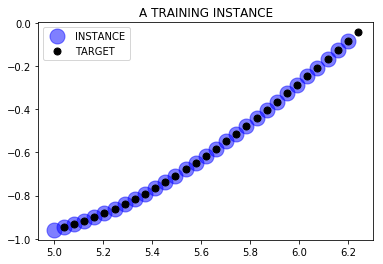

In [24]:
plt.title('A TRAINING INSTANCE')
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]),'bo', markersize=15, alpha=0.5, label='INSTANCE')
plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]),'ko', markersize=7, label='TARGET')
plt.legend()